In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.io import *
from fastai.conv_learner import *
from fastai.text import *
from fastai.column_data import *

In [2]:
from fsm import *

In [3]:
DATA_PATH = Path('data')
DATA_PATH
TMP_PATH = DATA_PATH/'tmp'
TMP_PATH.mkdir(exist_ok=True)

In [4]:
sql_ids = np.load(TMP_PATH/'sql_ids_char.npy')
sql_itos = pickle.load(open(TMP_PATH/'sql_itos_char.pkl','rb'))
sql_stoi =  collections.defaultdict(lambda: 3, {v:k for k,v in enumerate(sql_itos)})

In [5]:
def get_next_random(inp):
    idxs = T(np.array([char_indices[c] for c in inp]))
    p = m(*VV(idxs))
    p = to_np(p)[0]
    pi = p.argsort()[-10:]
    i = np.random.choice(pi, p=softmax_np(p[pi]))
    return indices_char[i]
def softmax_np (nparray):
    ans = np.exp(nparray)
    return ans/ans.sum()

def get_next(inp):
    idxs = T(np.array([char_indices[c] for c in inp]))
    p = m(*VV(idxs))
    i = np.argmax(to_np(p))
    p = to_np(p)
    
    return indices_char[i]

def get_sentence(inp):
    sentence = inp
    counter = 0
    tmp = []
    while "_eos_" not in tmp:   
        tmp = get_next(sentence[-8:]) # always get last three
        sentence += [tmp]
        counter = counter+1
        if counter> 500:
            break
    return sentence
        

def get_sentence_random(inp):
    sentence = inp
    counter = 0
    tmp = []
    while "_eos_" not in tmp:   
        tmp = get_next_random(sentence[-8:]) # always get last three
        sentence += [tmp]
        counter = counter+1
        if counter> 500:
            break
    return sentence
        

def show_sentence(inp):
    sentence =''
    captialize = False
    for i in inp:
        if i =='t_up':
            captialize = True
        else:            
            if captialize:
                sentence = sentence + " " + i.upper()       
           
            else:
                sentence = sentence +" " + i
            captialize = False
    return sentence

In [6]:
# fsm = Rule_Parse_FSM()

# get_next_random("select userid from users where ".split())

# get_next_random_fsm("select userid from users where ".split(), fsm)

## Setup

Set up directory path

In [6]:
!ls data

dev.db		  SQL_tok.pkl	     train.db		 TRN_PATHtrn.txt
dev.jsonl	  test.db	     train.json		 val
dev.tables.jsonl  test.jsonl	     train.tables.jsonl  VAL_PATH
nietzsche	  test.tables.jsonl  trn		 VAL_PATHval.txt
sql_queries.pkl   tmp		     TRN_PATH


In [33]:
PATH='data/'

TRN_PATH = 'trn/'
VAL_PATH = 'val/'

TRN = f'{PATH}{TRN_PATH}'
VAL = f'{PATH}{VAL_PATH}'
os.makedirs(TRN, exist_ok=True)
os.makedirs(VAL, exist_ok=True)
%ls {PATH}

dev.db            SQL_tok.pkl        train.db            TRN_PATHtrn.txt
dev.jsonl         test.db            train.json          val/
dev.tables.jsonl  test.jsonl         train.tables.jsonl  VAL_PATH/
nietzsche/        test.tables.jsonl  trn/                VAL_PATHval.txt
sql_queries.pkl   tmp/               TRN_PATH/


In [7]:
dataset = pd.read_json(DATA_PATH/'train.json')
dataset.head()
SQL = dataset.sql



In [8]:
SQL = SQL.str.lower()


In [9]:
SQL = SQL.apply(list)

In [10]:
sql_tok = SQL

In [12]:
lens=[len(i) for i in sql_tok]
lens= np.array(lens)

In [13]:
lens[:10]

array([1217,  831,   88,  599,  184,  186,  256,  352,  669,  123])

In [310]:
SQL.apply("".join).iloc[25]

"select postid as [post link], 'http://stackoverflow.com/posts/' + cast(p.id as varchar(100)) + '/revisions', text from posthistory ph join posts p on p.id = ph.postid where posthistorytypeid = 2 and text = upper(text) collate sql_latin1_general_cp1_cs_as and ph.creationdate > (select creationdate from posts where id = (select max(id) from posts)) - 30 and p.posttypeid = 1"

In [14]:
lens.mean(),lens.min(),lens.max(),lens.std()

(306.0687972676262, 1, 1922, 276.13404203894646)

In [15]:
sql_tok = [i for i in sql_tok if len(i)>=20] # Filter short sentence


lens=[len(i) for i in sql_tok]
lens= np.array(lens)

In [16]:
lens.mean(),lens.min(),lens.max(),lens.std()

(308.173247051114, 20, 1922, 276.03243266193437)

(array([0.48354, 0.74922, 0.87115, 0.93463, 0.96203, 0.97813, 0.98931, 0.99517, 0.99869, 1.     ]),
 array([  20. ,  210.2,  400.4,  590.6,  780.8,  971. , 1161.2, 1351.4, 1541.6, 1731.8, 1922. ]),
 <a list of 10 Patch objects>)

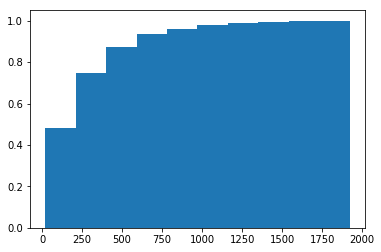

In [17]:
plt.hist(lens,cumulative=True,density=True)

In [18]:
tmp = len(sql_tok)
sql_tok = [i for i in sql_tok if len(i)>=4 and len(i)< int(lens.mean()+ 2*lens.std())] # Roughly 95% data
print('Filter',tmp-len(sql_tok), 'Long sentences')

SQL.iloc[0]

Filter 1251 Long sentences


['s',
 'e',
 'l',
 'e',
 'c',
 't',
 ' ',
 'p',
 '.',
 't',
 'i',
 't',
 'l',
 'e',
 ',',
 'p',
 '.',
 's',
 'c',
 'o',
 'r',
 'e',
 ',',
 'p',
 '.',
 'v',
 'i',
 'e',
 'w',
 'c',
 'o',
 'u',
 'n',
 't',
 ',',
 'p',
 '.',
 'a',
 'n',
 's',
 'w',
 'e',
 'r',
 'c',
 'o',
 'u',
 'n',
 't',
 ',',
 'p',
 '.',
 'c',
 'o',
 'm',
 'm',
 'e',
 'n',
 't',
 'c',
 'o',
 'u',
 'n',
 't',
 ',',
 'l',
 'e',
 'n',
 '(',
 'p',
 '.',
 'b',
 'o',
 'd',
 'y',
 ')',
 ' ',
 'a',
 's',
 ' ',
 'q',
 'u',
 'e',
 's',
 '_',
 's',
 'i',
 'z',
 'e',
 ',',
 ' ',
 'p',
 '.',
 'f',
 'a',
 'v',
 'o',
 'r',
 'i',
 't',
 'e',
 'c',
 'o',
 'u',
 'n',
 't',
 ',',
 'p',
 '.',
 'i',
 'd',
 ',',
 ' ',
 'u',
 '.',
 'r',
 'e',
 'p',
 'u',
 't',
 'a',
 't',
 'i',
 'o',
 'n',
 ' ',
 'a',
 's',
 ' ',
 'u',
 's',
 'e',
 'r',
 '_',
 'r',
 'e',
 'p',
 'o',
 ',',
 'u',
 '.',
 'c',
 'r',
 'e',
 'a',
 't',
 'i',
 'o',
 'n',
 'd',
 'a',
 't',
 'e',
 ' ',
 'a',
 's',
 ' ',
 'u',
 's',
 'e',
 'r',
 '_',
 'j',
 'o',
 'i',
 'n',
 '_',
 'd'

In [24]:
len(sql_tok)

23165

In [25]:
def toks2ids(tok,pre):
    freq = Counter(p for o in tok for p in o)
    itos = [o for o,c in freq.most_common() ] ## Avoid rare tokens
    itos.insert(0, '_bos_')
    itos.insert(1, '_pad_')
    itos.insert(2, '_eos_')
    itos.insert(3, '_unk')
    stoi = collections.defaultdict(lambda: 3, {v:k for k,v in enumerate(itos)})
    ids = np.array([([0] + [stoi[o] for o in p] + [2]) for p in tok]) # pad bos at beginning and eos at the end
    np.save(TMP_PATH/f'{pre}_ids_char.npy', ids)
    pickle.dump(itos, open(TMP_PATH/f'{pre}_itos_char.pkl', 'wb'))
    return ids,itos,stoi

In [26]:
sql_ids,sql_itos,sql_stoi = toks2ids(sql_tok,'sql')

In [6]:
sql_ids_concat = sql_ids # hacking

In [7]:
sql_ids_concat= []
for i in sql_ids:
    sql_ids_concat += i

In [8]:
len(sql_ids_concat)

6118914

In [9]:
# val_fraction = 0.2
# text_length = len(sql_ids)


# trn_lm = sql_ids[:-int(val_fraction*text_length)]
# val_lm = sql_ids[-int(val_fraction*text_length):]

# np.save(TRN+ 'trn_ids.npy', trn_lm)
# np.save(VAL+'val_ids.npy', val_lm)

# trn_lm = np.load(TRN+ 'trn_ids.npy')
# val_lm = np.load(VAL+'val_ids.npy')

# bs=64
# bptt=70
# n_fac=42; n_hidden=256

# trn_dl = LanguageModelLoader(np.concatenate(trn_lm),bs, bptt)
# val_dl = LanguageModelLoader(np.concatenate(val_lm),bs, bptt)

# trn_lm.shape, val_lm.shape

# md = LanguageModelData(PATH, 1 ,len(sql_itos), trn_dl, val_dl)

# bidir=True
# dropout=0.5

# class CharSeqStatefulGRU(nn.Module):
#     def __init__(self, vocab_size, n_fac, bs):
#         super().__init__()
#         self.vocab_size = vocab_size
#         self.e = nn.Embedding(vocab_size, n_fac)
#         self.rnn1 = nn.GRU(n_fac, n_hidden, dropout=dropout, bidirectional=bidir)
#         self.rnn2 = nn.GRU(n_hidden+n_hidden*bidir, n_hidden//2,dropout=dropout, bidirectional=bidir)
#         self.l_out = nn.Linear(n_hidden//2 +n_hidden//2 *bidir, vocab_size)
#         self.init_hidden(bs)
        
#     def forward(self, *cs):
#         bs = cs[0].size(0)
#         if self.h1.size(1) != bs: self.init_hidden(bs)
#         inp = self.e(torch.stack(cs))
#         outp,h1 = self.rnn1(inp, self.h1)
# #         outp = self.rnn_drop1(outp)
#         self.h1 = repackage_var(h1)
#         outp,h2 = self.rnn2(outp,self.h2)        
#         self.h2 = repackage_var(h2)
# #         outp = self.rnn_drop2(outp)
        
# #         pdb.set_trace()
#         return F.log_softmax(self.l_out(outp), dim=-1)
    
#     def init_hidden(self, bs): 
#         self.h1 = V(torch.zeros(1+1*bidir, bs, n_hidden))
#         self.h2 = V(torch.zeros(1+1*bidir, bs, n_hidden//2))

# def nll_loss_seq(inp, targ):
#     sl,bs,nh = inp.size()
#     targ = targ.transpose(0,1).contiguous().view(-1)
#     return F.nll_loss(inp.view(-1,nh), targ)

# tmp = next(iter(md.trn_dl))

# tmp



# m = CharSeqStatefulGRU(len(sql_itos), n_fac, bs=bs)
# opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
# learn = RNN_Learner(md, SingleModel(to_gpu(m)), opt_fn=opt_fn)
# learn.crit = nll_loss_seq

# learn.fit(1e-2, 1, cycle_len=5, use_clr_beta = (10,10,0.95,0.85))

In [10]:
sql_ids.shape

(23165,)

In [11]:
vocab_size = len(sql_itos)
print('total words:', vocab_size)

total words: 218


### Create inputs

Create a list of every 4th character, starting at the 0th, 1st, 2nd, then 3rd characters

In [12]:
idx = sql_ids_concat

In [13]:
char_indices = sql_stoi
indices_char = sql_itos

### Create and train model

Pick a size for our hidden state

## Multi-output model

### GRU

In [14]:
import pdb

In [15]:
def nll_loss_seq(inp, targ):
    sl,bs,nh = inp.size()
    targ = targ.transpose(0,1).contiguous().view(-1)
    return F.nll_loss(inp.view(-1,nh), targ)

## Change CS length

Bidir is clearly important, and it make sense as table schema comes after column name.
Set Bidir to true and test longer cs=16, and test differe n_hidden and n_fac


In [16]:
idx_tmp = idx.copy()

In [17]:
idx = idx[:200000].copy()

In [88]:
cs=8
# c_in_dat = [[idx[i+j] for i in range(cs)] for j in range(0, len(idx)-cs-1, cs)]
# c_out_dat = [[idx[i+j] for i in range(cs)] for j in range(1, len(idx)-cs, cs)]

c_in_dat = [[idx[i+j] for i in range(cs)] for j in range(len(idx)-cs)]
c_out_dat = [idx[j+cs] for j in range(len(idx)-cs)]

xs = np.stack(c_in_dat)
print(xs.shape)

ys = np.stack(c_out_dat)
print(ys.shape)

xs = np.stack(c_in_dat)
print(xs.shape)

ys = np.stack(c_out_dat)
print(ys.shape)

(199992, 8)
(199992,)
(199992, 8)
(199992,)


In [101]:
c_in_dat[:10]

[[0, 15, 10, 5, 9, 6, 5, 4],
 [15, 10, 5, 9, 6, 5, 4, 6],
 [10, 5, 9, 6, 5, 4, 6, 9],
 [5, 9, 6, 5, 4, 6, 9, 31],
 [9, 6, 5, 4, 6, 9, 31, 17],
 [6, 5, 4, 6, 9, 31, 17, 5],
 [5, 4, 6, 9, 31, 17, 5, 4],
 [4, 6, 9, 31, 17, 5, 4, 34],
 [6, 9, 31, 17, 5, 4, 34, 15],
 [9, 31, 17, 5, 4, 34, 15, 16]]

In [23]:
''.join([sql_itos[i] for i in xs[0]])

'_bos_create '

In [24]:
''.join([sql_itos[i] for i in ys[0]])

'create t'

In [25]:
bs=256

In [26]:
val_idx = get_cv_idxs(len(xs)-cs-1)
md = ColumnarModelData.from_arrays('.', val_idx, xs, ys, bs=bs)

In [125]:
bidir=False

In [173]:
class CharSeqStatefulGRU(nn.Module):
    def __init__(self, vocab_size, n_fac, bs):
        super().__init__()
        self.vocab_size = vocab_size
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn1 = nn.GRU(n_fac, n_hidden, num_layers=1, dropout=dropout, bidirectional=False)
#         self.rnn2 = nn.GRU(n_hidden+n_hidden*bidir, n_hidden//2,dropout=dropout, bidirectional=bidir)
        self.l_out = nn.Linear(n_hidden, vocab_size)
        self.init_hidden(bs)
        
    def forward(self, *cs):
        bs = cs[0].size(0)
        if self.h1.size(1) != bs: self.init_hidden(bs)
        inp = self.e(torch.stack(cs))
        outp,h1 = self.rnn1(inp, self.h1)
#         outp = self.rnn_drop1(outp)
        self.h1 = repackage_var(h1)
#         outp,h2 = self.rnn2(outp,self.h2)        
#         self.h2 = repackage_var(h2)
#         outp = self.rnn_drop2(outp)
        
#         pdb.set_trace()
#         return F.log_softmax(self.l_out(outp), dim=-1)
        return F.log_softmax(self.l_out(outp), dim=-1)
    
    def init_hidden(self, bs): 
        self.h1 = V(torch.zeros(1, bs, n_hidden))
#         self.h2 = V(torch.zeros(1+1*bidir, bs, n_hidden//2))

In [155]:
n_hidden =64
n_fac=32
dropout=0
bidir=True

In [156]:
# def accuracy(preds, targs):
#     preds = torch.max(preds.view(-1,len(sql_itos)), dim=1)[1]
#     targs = targs.transpose(0,1).contiguous().view(-1)
#     return (preds==targs).float().mean()
def accuracy(preds, targs):
    preds = torch.max(preds.view(-1,len(sql_itos)), dim=1)[1]
    targs = targs.transpose(0,1).contiguous().view(-1)
    return (preds==targs).float().mean()


In [174]:
print('n_hidden:',n_hidden,'n_fac:',n_fac,'bidir:',bidir,'dropout:',dropout)
            
m = CharSeqStatefulGRU(len(sql_itos), n_fac, bs=bs)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
learn = RNN_Learner(md, SingleModel(to_gpu(m)), opt_fn=opt_fn)
# learn.crit = nll_loss_seq
learn.crit = nll_loss_seq
learn.metrics = [accuracy]
learn.fit(1e-2, 5, cycle_len=1, use_clr_beta = (10,10,0.95,0.85))

n_hidden: 64 n_fac: 32 bidir: True dropout: 0


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      2.794923   2.416535   0.356618  



[array([2.41654]), 0.3566176459735849]

In [158]:
??F.nll_loss

In [181]:
learn.fit(1e-2, 1, cycle_len=5, use_clr_beta = (10,10,0.95,0.85))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.501184   1.546828   0.58741   
    1      1.501011   1.552246   0.582733                 
    2      1.499671   1.529108   0.589661                 
    3      1.474694   1.504407   0.596564                 
    4      1.452157   1.494146   0.597864                 



[array([1.49415]), 0.5978641435593403]

In [183]:
learn.fit(1e-4, 1, cycle_len=5, use_clr_beta = (10,10,0.95,0.85))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.436027   1.491136   0.59929   
    1      1.434619   1.490862   0.59924                  
    2      1.43159    1.490431   0.599365                 
    3      1.435149   1.490194   0.599565                 
    4      1.43776    1.490163   0.599565                 



[array([1.49016]), 0.5995648238075977]

In [184]:
def get_next(inp):
    idxs = T(np.array([char_indices[c] for c in inp]))
    p = m(*VV(idxs))
    p = to_np(p)    
    i = np.argmax(p[-1,:,:])
#     i =np.argmax(p)
    
    return indices_char[i]

In [185]:
''.join([ indices_char[i] for i in sql_ids[1]])

"_bos_select id from comments where lower(text) like '%accept %answer%' order by len(text) asc_eos_"

In [186]:
def sentence(inp):
    counter = 0
    tmp =inp
    for i in range(600):
        tmp = tmp + get_next(tmp[-70:])
    return tmp

In [187]:
tmp = next(iter(md.val_dl))

In [188]:
['update','select','insert','delete'][0]    

'update'

In [189]:
def test_case():
    sample = ['updat','selec','delet','inser']
    for i in sample:
        print('Input:', i, 'output:', i+get_next(i))
              
    sample = ['update','select','insert','delete']          
    for i in sample:
            print('Input:', i, 'output:', sentence(i))    

In [190]:
get_next('updat')

'e'

In [191]:
test_case()

Input: updat output: update
Input: selec output: select
Input: delet output: deleti
Input: inser output: insert
Input: update output: update as [post link], reputation desc_eos_tags p where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where po
Input: select output: select top 100 and posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts wher

In [192]:
test_case()

Input: updat output: update
Input: selec output: select
Input: delet output: deleti
Input: inser output: insert
Input: update output: update as [post link], reputation desc_eos_tags p where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where po
Input: select output: select top 100 and posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts where posts wher

# Test on old text file see if error